In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
clobber = False

## Get the model grid and generate region mask
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [3]:
grid = pop_tools.get_grid('POP_gx1v6')
#grid

In [4]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
grid = grid.isel(nlat=lat_slice)
#grid

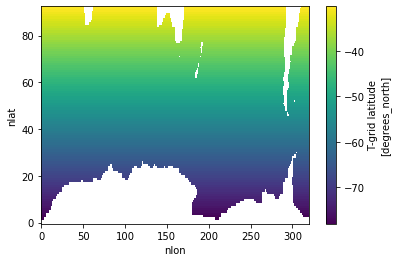

In [5]:
grid.TLAT.where(grid.KMT>0).plot();

In [6]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('WAP & Atlantic', so_logic & ((grid.TLONG > 260) | (grid.TLONG < 25))),
#    ('Indo-Pacific', so_logic & ~((grid.TLONG > 260) | (grid.TLONG < 25))),    
]

# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)


# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)
#masked_area    

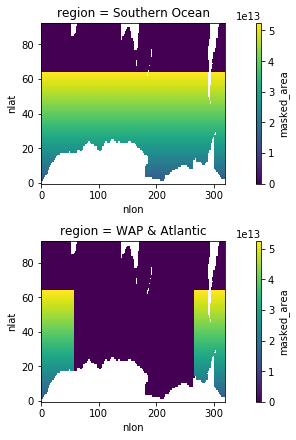

In [7]:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()    

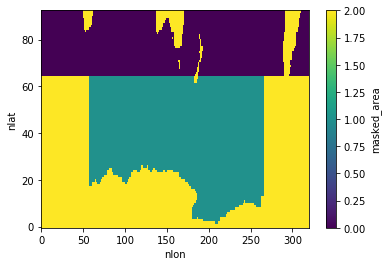

In [8]:
masked_area.where(masked_area==0).fillna(1.).sum('region').plot();

## Open Global Dataset

In [9]:
ds_djf_obs = xr.open_zarr(f'{util.project_tmpdir}/seawifs_mapped_monthly_chl_gsm_DJF.POP_gx1v6.zarr')
ds_djf_obs

<xarray.Dataset>
Dimensions:  (lat: 384, lon: 320, nlat: 384, nlon: 320, time: 12)
Coordinates:
    TLAT     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLONG    (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
  * time     (time) int64 1998 1999 2000 2001 2002 ... 2005 2006 2007 2009 2010
Dimensions without coordinates: lat, lon, nlat, nlon
Data variables:
    KMT      (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA    (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    chl_gsm  (time, lat, lon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

### Clip it to SO

In [10]:
#for consistency.. rename chl
#ds_djf_obs['Chl_surf'] = ds_djf_obs['chl_gsm']

#then select what to take.....
grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'time']
#data_vars = ['Chl_surf']
data_vars = ['chl_gsm']

# and slice it up!
ds_obs = ds_djf_obs[data_vars+grid_vars].isel(nlat=lat_slice)
ds_obs

<xarray.Dataset>
Dimensions:  (lat: 384, lon: 320, nlat: 93, nlon: 320, time: 12)
Coordinates:
    TLAT     (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
    TLONG    (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
  * time     (time) int64 1998 1999 2000 2001 2002 ... 2005 2006 2007 2009 2010
Dimensions without coordinates: lat, lon, nlat, nlon
Data variables:
    chl_gsm  (time, lat, lon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMT      (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>
    TAREA    (time, nlat, nlon) float64 dask.array<chunksize=(1, 93, 320), meta=np.ndarray>

## Amp things up cuz its being 

## Run to generate regional time series:

In [11]:
%%time
name = 'seawifs-djf-regional-timeseries'
@xp.persist_ds(name=name, format='zarr', path='data', trust_cache=True, clobber=clobber)
def regional_means():
    
    ds_djf = ds_obs

    #ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
    
    dim = ['nlat', 'nlon']
    area_total = masked_area.sum(dim)
    weights = masked_area / area_total
    weights_sum = weights.sum(dim)

    # ensure that the weights add to 1.
    np.testing.assert_allclose(weights_sum.where(weights_sum != 0.).fillna(1.), 1.0, rtol=1e-7)

    with xr.set_options(keep_attrs=True):
        ds_djf_regional = (ds_djf[list(ds_djf.data_vars)] * weights).sum(dim).compute()

    return ds_djf_regional

ds_djf_regional = regional_means()
ds_djf_regional

KeyboardInterrupt: 